In [33]:
from __future__ import division, print_function, unicode_literals

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np
#import os

import warnings
warnings.filterwarnings('ignore')
dataset = pd.read_csv('./data/labeledTrainData.tsv', delimiter = '\t', quoting = 3)
dataset = dataset.drop('id', 1)

In [83]:

dataset.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [70]:
dataset.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
vect = CountVectorizer()
X_train,X_test,y_train,y_test = train_test_split(dataset["review"], dataset["sentiment"], test_size=0.2, random_state=10)
vect.fit(X_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)




(20000,)
(5000,)
(20000,)
(5000,)


In [59]:
X_test_df

<2500x71740 sparse matrix of type '<class 'numpy.int64'>'
	with 340682 stored elements in Compressed Sparse Row format>

In [51]:
prediction = dict()
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df,y_train)
prediction["Multinomial"] = model.predict(X_test_df)
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
accuracy_score(y_test,prediction["Multinomial"])

0.8436

In [55]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_df,y_train)
prediction["Logistic"] = model.predict(X_test_df)
print(accuracy_score(y_test,prediction["Logistic"]))

0.886


[[1123  154]
 [ 237  986]]
[1 1 0 ... 0 0 0]


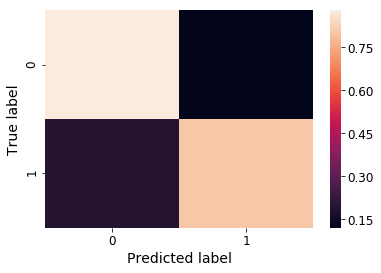

In [58]:
conf_mat = confusion_matrix(y_test, prediction['Multinomial'])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(conf_mat)

[[1109  168]
 [ 117 1106]]


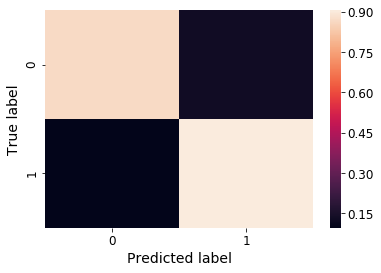

In [56]:

conf_mat = confusion_matrix(y_test, prediction['Logistic'])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(conf_mat)

In [60]:
#creating own implementation of Naive Bayes with BoW and simple string conversion:
import pandas as pd
import numpy as np
from collections import defaultdict
import re

def preprocess_string(str_arg):
    cleaned_str = re.sub('[^a-z\s]+', ' ', str_arg, flags=re.IGNORECASE)  # every char except alphabets is replaced
    cleaned_str = re.sub('(\s+)', ' ', cleaned_str)  # multiple spaces are replaced by single space
    cleaned_str = cleaned_str.lower()  # converting the cleaned string to lower case

    return cleaned_str  # eturning the preprocessed string in tokenized form


class NaiveBayes:

    def __init__(self, unique_classes):

        self.classes = unique_classes  # Constructor is sinply passed with unique number of classes of the training set

    def addToBow(self, example, dict_index):

        if isinstance(example, np.ndarray): example = example[0]

        for token_word in example.split():  # for every word in preprocessed example

            self.bow_dicts[dict_index][token_word] += 1  # increment in its count

    def train(self, dataset, labels):

        self.examples = dataset
        self.labels = labels
        self.bow_dicts = np.array([defaultdict(lambda: 0) for index in range(self.classes.shape[0])])

        if not isinstance(self.examples, np.ndarray): self.examples = np.array(self.examples)
        if not isinstance(self.labels, np.ndarray): self.labels = np.array(self.labels)

        # constructing BoW for each category
        for cat_index, cat in enumerate(self.classes):
            all_cat_examples = self.examples[self.labels == cat]  # filter all examples of category == cat
            cleaned_examples = [preprocess_string(cat_example) for cat_example in all_cat_examples]
            cleaned_examples = pd.DataFrame(data=cleaned_examples)

            # now costruct BoW of this particular category
            np.apply_along_axis(self.addToBow, 1, cleaned_examples, cat_index)

        prob_classes = np.empty(self.classes.shape[0])
        all_words = []
        cat_word_counts = np.empty(self.classes.shape[0])
        for cat_index, cat in enumerate(self.classes):
            # Calculating prior probability p(c) for each class
            prob_classes[cat_index] = np.sum(self.labels == cat) / float(self.labels.shape[0])

            # Calculating total counts of all the words of each class
            count = list(self.bow_dicts[cat_index].values())
            cat_word_counts[cat_index] = np.sum(
                np.array(list(self.bow_dicts[cat_index].values()))) + 1  # |v| is remaining to be added

            # get all words of this category
            all_words += self.bow_dicts[cat_index].keys()

        # combine all words of every category & make them unique to get vocabulary -V- of entire training set

        self.vocab = np.unique(np.array(all_words))
        self.vocab_length = self.vocab.shape[0]

        # computing denominator value
        denoms = np.array(
            [cat_word_counts[cat_index] + self.vocab_length + 1 for cat_index, cat in enumerate(self.classes)])

        self.cats_info = [(self.bow_dicts[cat_index], prob_classes[cat_index], denoms[cat_index]) for cat_index, cat in
                          enumerate(self.classes)]
        self.cats_info = np.array(self.cats_info)

    def getExampleProb(self, test_example):

        likelihood_prob = np.zeros(self.classes.shape[0])  # to store probability w.r.t each class

        # finding probability w.r.t each class of the given test example
        for cat_index, cat in enumerate(self.classes):

            for test_token in test_example.split():  # split the test example and get p of each test word

                ####################################################################################

                # This loop computes : for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ]

                ####################################################################################

                # get total count of this test token from it's respective training dict to get numerator value
                test_token_counts = self.cats_info[cat_index][0].get(test_token, 0) + 1

                # now get likelihood of this test_token word
                test_token_prob = test_token_counts / float(self.cats_info[cat_index][2])

                # remember why taking log? To prevent underflow!
                likelihood_prob[cat_index] += np.log(test_token_prob)

        # we have likelihood estimate of the given example against every class but we need posterior probility
        post_prob = np.empty(self.classes.shape[0])
        for cat_index, cat in enumerate(self.classes):
            post_prob[cat_index] = likelihood_prob[cat_index] + np.log(self.cats_info[cat_index][1])

        return post_prob

    def test(self, test_set):

        predictions = []  # to store prediction of each test example
        for example in test_set:
            # preprocess the test example the same way we did for training set exampels
            cleaned_example = preprocess_string(example)

            # simply get the posterior probability of every example
            post_prob = self.getExampleProb(cleaned_example)  # get prob of this example for both classes

            # simply pick the max value and map against self.classes!
            predictions.append(self.classes[np.argmax(post_prob)])

        return np.array(predictions)



In [77]:
nb=NaiveBayes(np.unique(y_train)) #instantiate a NB class object

In [92]:
nb.train(X_train.values,y_train.values)


In [93]:
pclasses=nb.test(X_test.values)
print(pclasses)

test_acc=np.sum(pclasses==y_test.values)/float(y_test.values.shape[0])
print ("Test Set Examples: ",y_test.values.shape[0])
print ("Test Set Accuracy: ",test_acc*100,"%")

Test Set Examples:  5000
Test Set Accuracy:  0.0 %


In [98]:
test_acc=np.sum(pclasses==y_test.values)/float(y_test.values.shape[0])
print ("Test Set Examples: ",y_test.values.shape[0])
print ("Test Set Accuracy: ",test_acc*100,"%")
print(pclasses)
print(y_test.values)
print(test_acc)

Test Set Examples:  5000
Test Set Accuracy:  84.22 %
[1 1 0 ... 0 1 0]
[1 1 0 ... 0 1 0]
0.8422


In [67]:
print(y_test)

18634    1
1333     1
20315    0
6357     0
10496    1
23567    1
501      0
11332    0
1744     1
19340    0
15097    0
24068    0
12727    0
21140    1
8872     0
15312    0
5009     0
13243    1
19796    1
20175    1
14844    0
2355     1
10068    1
14586    1
14990    0
21034    0
2859     1
3571     0
2673     1
23270    1
        ..
7310     0
10519    1
7443     1
15489    0
246      1
6442     0
18370    1
6240     1
1769     0
22574    1
1958     1
16311    0
11630    1
2236     0
11292    1
7025     0
5205     1
6909     1
2882     1
2344     1
5830     0
68       1
10467    0
11092    1
9800     0
22565    0
3909     1
1096     0
12573    0
6581     0
Name: sentiment, Length: 2500, dtype: int64
